In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fungiinfo = pd.read_csv('AllfungiData.csv',header =0) #moisture To 是容忍度
tempCurve = pd.read_csv('curves_temperature.csv',header=0)
moisCurve = pd.read_csv('curve_moisture.csv',header = 0)
tempCurve['tempaxis'] = np.around(tempCurve['tempaxis'],2)

fungiinfo.drop(labels=[34,35],axis=0,inplace=True)

names = fungiinfo['name3']
maxx = []

for item in names:
    #print(item)
    trymax1 = np.max(tempCurve[item])
    trymax2 = np.max(moisCurve[item])
    trymax3 = fungiinfo[fungiinfo['name3']==item]['rate.0.5'].tolist()
    trymax3.append(trymax2)
    trymax3.append(trymax1)
    #print(trymax3)
    maxx.append([trymax2,trymax1,np.max(trymax3)])#湿度 温度 最高
fungiMax = dict(zip(names,maxx))
fungiMax



def getV(mois,temp,name):
    maxx = fungiMax[name]
    getmois = moisCurve[moisCurve['wateraxis']==mois][name].tolist()
    gettemp = tempCurve[tempCurve['tempaxis']==temp][name].tolist()
    #print(mois)
    getmois=getmois[0]
    
    #print(str(temp))
    gettemp=gettemp[0]
    
    r1 = getmois/maxx[0]
    r2 = gettemp/maxx[1]

    r = 2*(r1*r2)/(r1+r2)
    f = maxx[2]*r
    
    getmoisT = fungiinfo[fungiinfo['name3']==name]['moisture To'].tolist()
    g = getmoisT[0]
    lvi = -0.32 + 0.23*f + 0.22*g+ -0.038*f*g 
    
    result = np.exp(lvi)
    return result,f
    
def LotkaVolterra(moislist,templist,namelist):
    decomposite_all = np.zeros(len(moislist))
    #时间长度在给定的list里都有了0.0
    #先对每个初始化吧;
    dictfungi = {}
    for name in namelist:
        dictfungi[name] = [[],[1],[1]]#这里还没想好但总而言之是多个列表啊 第一个存当前的v？第二个存当前的N 第三个存当前的N*V
    for days in range(len(moislist)):
        

        filist  = []
        vilist = []
        for name in namelist:
            vi,fi = getV(moislist[days],templist[days],name)
            #dictfungi[name][0].append([vi,fi])
            filist.append(fi)
            vilist.append(vi)
        #对fi 归一化 min-max scaling 
        maxfi = max(filist)
        filist = np.array(filist)
        filist = filist/maxfi
        for index in range(len(filist)):
            name = namelist[index]
            dictfungi[name][0].append([vilist[index],filist[index]])
        
        
        for name in namelist:
            fi = dictfungi[name][0][days][1]
            #print(str(fi))
            vi = dictfungi[name][0][days][0]
            #print(str(vi))
            N = dictfungi[name][1][days]
            #print(str(N)+'day'+str(days))
            sumup=0
            for name1 in namelist:
                    sumup = sumup + dictfungi[name1][0][days][1]/fi*dictfungi[name1][1][days]/100#1k为设定的环境容纳量/好像太大了换成100 
            dsize = fi*N*(1-sumup) 
            size =max(N +dsize,0.001) #总而言之是不能小于零的啊qaq #从0改成0.001
            dictfungi[name][1].append(size)
            dictfungi[name][2].append(vi*size)
            decomposite_all[days]=decomposite_all[days]+vi*size
            
    

    return dictfungi,decomposite_all

In [110]:
#在更长的时间轴上来看吧
Am_m = np.append(np.ones(5)*(-0.5),np.around(np.random.normal(loc=-0.5,scale=0.05,size=100) ,2))
A_t = np.append(np.ones(5)*27,np.around(np.random.normal(loc = 27,scale=2,size=100),2))


time = range(106)
time1 = range(105)

In [111]:
#两组，每组两张好了，第一张是最多种的时候的population 第二张是decomposition rate的变化
#第一组是普通气温波动，第二组是突发的气候变化
subnames = ['p.flav.s','p.flav.n','m.trem.s','m.trem.n','p.rufa.acer.s','p.sang.s']
subname1 = ['p.flav.s','p.flav.n']
subname2 = ['p.flav.s']

tfuninfo4,tdecomposition4 = LotkaVolterra(Am_m,A_t,subnames)
tfuninfo3,tdecomposition3 = LotkaVolterra(Am_m,A_t,subname1)
tfuninfo2,tdecomposition2 = LotkaVolterra(Am_m,A_t,subname2)

In [149]:
A_t_flua =np.around(np.append(np.ones(5)*25,np.linspace(20,45,100)),2)
Am_m_flua = np.around(np.append(np.ones(5)*(-0.5),np.linspace(-0.5,-0.2,100)),2)

In [113]:
A_t_flua[A_t_flua>50]=50
A_t_flua = np.round(A_t_flua,2)

In [147]:
tfuninfo7,tdecomposition7 = LotkaVolterra(Am_m_flua,A_t_flua,subnames)
tfuninfo6,tdecomposition6 = LotkaVolterra(Am_m_flua,A_t_flua,subname1)
tfuninfo5,tdecomposition5 = LotkaVolterra(Am_m_flua,A_t_flua,subname2)

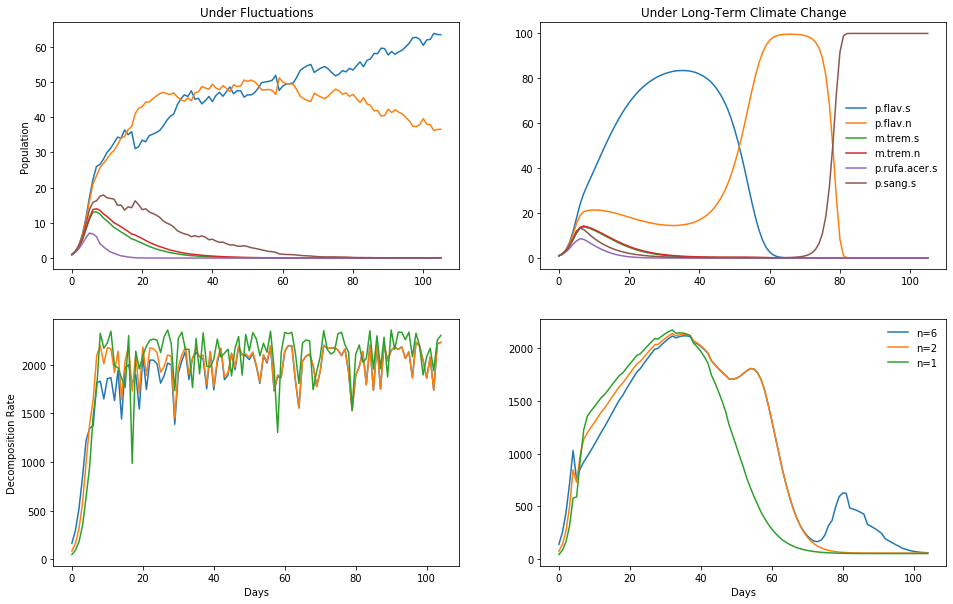

In [153]:
fig = plt.figure(figsize=(16,10),facecolor='white')
ax1 = fig.add_subplot(221)
for item in subnames:
    N = tfuninfo4[item][1]
    plt.plot(time,N,label=item)
#plt.title('Population growth(n=6)')
plt.title('Under Fluctuations')
plt.ylabel("Population")
#plt.legend(frameon = False)

ax2 = fig.add_subplot(223)
plt.plot(time1,tdecomposition4,label = 'n=6')
plt.plot(time1,tdecomposition3,label = 'n=2')
plt.plot(time1,tdecomposition2,label = 'n=1')
plt.xlabel("Days")
plt.ylabel('Decomposition Rate')
#plt.legend(frameon = False)

ax3 = fig.add_subplot(222)
for item in subnames:
    N = tfuninfo7[item][1]
    plt.plot(time,N,label=item)
plt.title('Under Long-Term Climate Change')
plt.legend(frameon = False)

ax4 = fig.add_subplot(224)
plt.plot(time1,tdecomposition7,label = 'n=6')
plt.plot(time1,tdecomposition6,label = 'n=2')
plt.plot(time1,tdecomposition5,label = 'n=1')
plt.xlabel("Days")
#plt.ylabel('Decomposition Rate')
plt.legend(frameon = False)

plt.savefig('task5.jpg')

In [9]:
# Wisconsin = pd.read_csv('Wisconsin1.csv',header=0)
# Wisconsin
# 
# w_tempreture = Wisconsin['Celsius'].tolist()
# w_tempreture = np.around(w_tempreture,2)
# w_tempreture[w_tempreture<-0.5]=-0.5
# w_tempreture

array([-0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.5 ,
       -0.5 , -0.5 , -0.5 , -0.5 , -0.5 , -0.28, -0.06,  0.17,  0.39,
        0.61,  0.83,  1.06,  1.28,  1.5 ,  1.72,  1.94,  2.17,  2.39,
        2.61,  2.83,  3.06,  3.28,  3.5 ,  3.72,  3.94,  4.17,  4.39,
        4.61,  4.83,  5.06,  5.28,  5.5 ,  5.72,  5.94,  6.17,  6.39,
        6.61,  6.83,  7.06,  7.22,  7.44,  7.67,  7.89,  8.06,  8.28,
        8.5 ,  8.67,  8.89,  9.06,  9.28,  9.44,  9.67,  9.83, 10.06,
       10.22, 10.44, 10.61, 10.78, 11.  , 11.17, 11.33, 11.56, 11.72,
       11.89, 12.11,

In [55]:
# w_moisture = np.linspace(-1.7,-0.5,183)
# w_moisture_ = np.linspace(-0.5,-1.7,183)
# w_moisture_f = np.append(w_moisture,w_moisture_)
# w_moisture = np.append(w_moisture_f,w_moisture_f)
# w_moisture_n = np.random.normal(loc=0,scale=0.3,size=732)
# w_moisture = np.around(w_moisture + w_moisture_n,2)
# w_moisture[w_moisture>0]=0

In [26]:
dels = ['p.flav.s','p.flav.n','m.trem.s','m.trem.n','p.rufa.acer.s','p.rufa.acer.n']

for item in dels:
    subnames.remove(item)

In [64]:
subnames1 = ['p.flav.s','p.flav.n','m.trem.s','m.trem.n','p.rufa.acer.n']
subnames2 = ['p.flav.n','s.comm.n','p.sang.s','p.flav.n']

In [65]:
tfuninfo4,tdecomposition4 = LotkaVolterra(w_moisture,w_tempreture,subnames2)

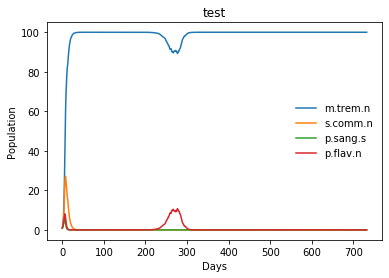

In [66]:
time = range(733)
plt.figure(facecolor='white')
for item in subnames2:
    N = tfuninfo4[item][1]
    plt.plot(time,N,label=item)
plt.title('test')
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend(frameon = False)

In [29]:
maxinfo = {}
for keys in tfuninfo4:
    
    thiso = tfuninfo4[keys][1][100]
    maxinfo[keys] = thiso
maxinfo



{'a.gal1.s': 3.28615116201591e-70,
 'a.gal10.n': 2.916041170603708e-157,
 'a.gal2.s': 1.1561407897228799e-74,
 'a.gal3.s': 1.9272609861418545e-83,
 'a.gal5.s': 3.4429880848295466e-85,
 'a.gal6.n': 1.656540699352658e-119,
 'a.gal8.n': 8.781250242247133e-126,
 'a.gal9.n': 3.3479512928386977e-286,
 'a.sin.n': 2.544445172126941e-80,
 'a.tab.n': 2.7900417398237024e-77,
 'a.tab.s': 7.936638056078149e-145,
 'f.fom.n': 1.6511053228661636e-209,
 'h.crust.n': 2.938383966916481e-19,
 'h.seti.n': 2.48042777868896e-50,
 'h.seti.s': 1.152929197606167e-145,
 'l.conif.n': 1.6263237848499304e-64,
 'l.crin.s': 3.5258749992433533e-43,
 'm.meri.s': 4.7172147264400925e-90,
 'p.gilv.n': 1.587964818667225e-24,
 'p.har.n': 2.913643267195017e-57,
 'p.pend.n': 1.5882184373279434e-62,
 'p.robin.n': 5.018092898337095e-112,
 'p.robin.s': 5.279870634188981e-125,
 'p.sang.s': 6.70502586116866e-19,
 's.comm.n': 100.0,
 's.comm.s': 5.767090923390112e-76,
 't.chion.n': 2.3953081551437464e-39,
 'x.sub.s': 9.206384255521

In [30]:
singleGenerated = pd.read_csv('singleSpecies.csv',header = 0)
nowis_ = singleGenerated[singleGenerated['Climate']=='semi-arid']
nowis_.sort_values(by='Means',inplace=True)
nowis_


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name3,Means,Vars,Climate
19,a.gal3.s,28.280640,68.229716,semi-arid
29,a.gal6.n,29.690643,75.336555,semi-arid
14,a.gal2.s,32.652360,90.955988,semi-arid
169,x.sub.s,33.921557,98.403412,semi-arid
4,a.gal1.s,38.205427,124.524409,semi-arid
49,a.tab.n,39.783148,135.803721,semi-arid
34,a.gal8.n,42.916461,157.229069,semi-arid
24,a.gal5.s,43.350885,160.395541,semi-arid
9,a.gal10.n,45.101302,173.719487,semi-arid
39,a.gal9.n,45.571071,177.491809,semi-arid


[4.8743238302]